In [ ]:
!pip install wget

In [ ]:
!wget http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishImg.tgz
!tar -xzf EnglishImg.tgz
!mv English/ chars74k
!rm EnglishImg.tgz

# some of the images for sample 53 have a different format, just remove them
!rm chars74k/Img/GoodImg/Bmp/Sample053/img053-00049.png
!rm chars74k/Img/GoodImg/Bmp/Sample053/img053-00028.png
!rm chars74k/Img/GoodImg/Bmp/Sample053/img053-00024.png
!rm chars74k/Img/GoodImg/Bmp/Sample053/img053-00009.png
!rm chars74k/Img/GoodImg/Bmp/Sample053/img053-00035.png

In [ ]:
import glob
import numpy as np
import random
from cv2 import resize
from matplotlib.image import imread
from matplotlib.pyplot import imshow
import cv2


SAMPLES = 7700
CHARS = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"
ROWS = 64
COLS = 64

images = np.zeros(shape=(SAMPLES, ROWS, COLS))
labels = np.zeros(shape=(SAMPLES,), dtype=int)
sample_num = 0
for sample in sorted(glob.glob('/content/chars74k/Img/GoodImg/Bmp/*')):
    for image in glob.glob(sample + '/*'):
        original_image = imread(image)
        resized_image = resize(original_image, dsize=(COLS, ROWS))
        grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
        images[sample_num] = grayscale_image
        labels[sample_num] = int(sample[-2:]) - 1
        sample_num += 1

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]

        # Apply the specified transform if provided
        if self.transform:
            image = self.transform(image)

        return image, 0

In [ ]:
pil_images = [Image.fromarray(image) for image in images]

transform = transforms.Compose([
    transforms.ToTensor(),
    # Add more transformations if needed
])

train_dataset = CustomDataset(pil_images, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

**Pre_train**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import cv2
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
def tensor_to_image(tensor):
    image = tensor.cpu().numpy()
    image = np.transpose(image, (1, 2, 0))
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    return image

In [ ]:
# Define the U-Net architecture
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )
        self.blur_module = BackwardBlurDDPM()

    def forward_blurring(self, x):
        blurred_x = self.blur_module(x)
        return blurred_x

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.decoder(x1)
        return x2

# Define the backward blur diffusion module
class BackwardBlurDDPM(nn.Module):
    def __init__(self):
        super(BackwardBlurDDPM, self).__init__()
        # Define the blur kernel
        self.kernel = nn.Parameter(torch.ones(1, 1, 7, 7) / 49)

    def forward(self, x):
        # Apply backward blur diffusion
        blurred_x = nn.functional.conv2d(x, self.kernel, padding=1, groups=1)
        return blurred_x

    def backward_deblur_ddim(self, blurred_x):
        # Apply backward deblurring using the blurred image
        deblurred_x = nn.functional.conv_transpose2d(blurred_x, self.kernel, padding=1, groups=1)
        return deblurred_x

# Define the training loop
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    criterion = nn.MSELoss()
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))



In [ ]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
#train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
#train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create the U-Net model
model = UNet().to(device)

# Create the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

generated_images = []
remove_blur = []
blur_images=[]
# Train the model
num_epochs = 50
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)

# Save some example images
with torch.no_grad():
    sample = next(iter(train_loader))[0].to(device)
    output = model(sample)
    save_image(torch.cat([sample, output], dim=0), 'output.png', nrow=8)
    generated_images.append(tensor_to_image(sample[0]))

# Recover the image without blur
with torch.no_grad():
    blurred_sample = model.forward_blurring(sample)
    recovered_sample = model.blur_module.backward_deblur_ddim(blurred_sample)
    save_image(torch.cat([sample, recovered_sample], dim=0), 'recovered.png', nrow=8)
    remove_blur.append(tensor_to_image(recovered_sample[0]))
    blur_images.append(tensor_to_image(blurred_sample[0]))


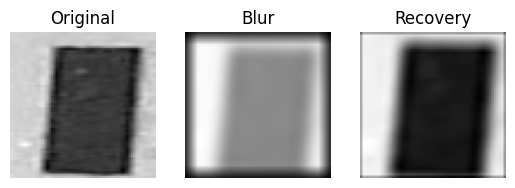

In [ ]:
# Create subplots
fig, axes = plt.subplots(1, 3)

# Plot the first image
axes[0].imshow(generated_images[0].squeeze(), cmap='gray')
axes[0].set_title('Original')


# Plot the second image
axes[1].imshow(remove_blur[0].squeeze(), cmap='gray')
axes[1].set_title('Blur')

# Plot the third image
axes[2].imshow(blur_images[0].squeeze(), cmap='gray')
axes[2].set_title('Recovery')

# Remove the axes from all subplots
for ax in axes:
    ax.axis('off')

In [ ]:
torch_tensor = torch.from_numpy(Letter_s)
torch_tensor = torch_tensor.unsqueeze(0).unsqueeze(0)

In [ ]:
import matplotlib.pyplot as plt
index=23
# Create subplots
fig, axes = plt.subplots(1, 3)

# Plot the first image
axes[0].imshow(sample.squeeze().cpu().numpy()[index],cmap='gray')
axes[0].set_title('Original')


# Plot the second image
axes[1].imshow(recovered_sample.squeeze().cpu().numpy()[index],cmap='gray')
axes[1].set_title('Blur')

# Plot the third image
axes[2].imshow(blurred_sample.squeeze().cpu().numpy()[index],cmap='gray')
axes[2].set_title('Recovery')

# Remove the axes from all subplots
for ax in axes:
    ax.axis('off')

In [ ]:
import glob
import numpy as np
import random
from cv2 import resize
from matplotlib.image import imread
from matplotlib.pyplot import imshow
import cv2

ROWS = 128
COLS = 128

E1 = imread('/content/Simulation/E1.png')
E1 = resize(E1, dsize=(COLS, ROWS))
E1 = cv2.cvtColor(E1, cv2.COLOR_BGR2GRAY)

E2 = imread('/content/Simulation/E2.png')
E2 = resize(E2, dsize=(COLS, ROWS))
E2 = cv2.cvtColor(E2, cv2.COLOR_BGR2GRAY)

E3 = imread('/content/Simulation/E3.png')
E3 = resize(E3, dsize=(COLS, ROWS))
E3 = cv2.cvtColor(E3, cv2.COLOR_BGR2GRAY)


P1 = imread('/content/Simulation/P1.png')
P1 = resize(P1, dsize=(COLS, ROWS))
P1 = cv2.cvtColor(P1, cv2.COLOR_BGR2GRAY)

P2 = imread('/content/Simulation/P2.png')
P2 = resize(P2, dsize=(COLS, ROWS))
P2 = cv2.cvtColor(P2, cv2.COLOR_BGR2GRAY)

P3 = imread('/content/Simulation/P3.png')
P3 = resize(P3, dsize=(COLS, ROWS))
P3 = cv2.cvtColor(P3, cv2.COLOR_BGR2GRAY)


R1 = imread('/content/Simulation/R1.png')
R1 = resize(R1, dsize=(COLS, ROWS))
R1 = cv2.cvtColor(R1, cv2.COLOR_BGR2GRAY)

R2 = imread('/content/Simulation/R2.png')
R2 = resize(R2, dsize=(COLS, ROWS))
R2 = cv2.cvtColor(R2, cv2.COLOR_BGR2GRAY)

R3 = imread('/content/Simulation/R3.png')
R3 = resize(R3, dsize=(COLS, ROWS))
R3 = cv2.cvtColor(R3, cv2.COLOR_BGR2GRAY)


S1 = imread('/content/Simulation/S1.png')
S1 = resize(S1, dsize=(COLS, ROWS))
S1 = cv2.cvtColor(S1, cv2.COLOR_BGR2GRAY)

S2 = imread('/content/Simulation/S2.png')
S2 = resize(S2, dsize=(COLS, ROWS))
S2 = cv2.cvtColor(S2, cv2.COLOR_BGR2GRAY)

S3 = imread('/content/Simulation/S3.png')
S3 = resize(S3, dsize=(COLS, ROWS))
S3 = cv2.cvtColor(S3, cv2.COLOR_BGR2GRAY)

T1 = imread('/content/Simulation/T1.png')
T1 = resize(T1, dsize=(COLS, ROWS))
T1 = cv2.cvtColor(T1, cv2.COLOR_BGR2GRAY)

T2 = imread('/content/Simulation/T2.png')
T2 = resize(T2, dsize=(COLS, ROWS))
T2 = cv2.cvtColor(T2, cv2.COLOR_BGR2GRAY)

T3 = imread('/content/Simulation/T3.png')
T3 = resize(T3, dsize=(COLS, ROWS))
T3 = cv2.cvtColor(T3, cv2.COLOR_BGR2GRAY)

V1 = imread('/content/Simulation/V1.png')
V1 = resize(V1, dsize=(COLS, ROWS))
V1 = cv2.cvtColor(V1, cv2.COLOR_BGR2GRAY)

V2 = imread('/content/Simulation/V2.png')
V2 = resize(V2, dsize=(COLS, ROWS))
V2 = cv2.cvtColor(V2, cv2.COLOR_BGR2GRAY)

V3 = imread('/content/Simulation/V3.png')
V3 = resize(V3, dsize=(COLS, ROWS))
V3 = cv2.cvtColor(V3, cv2.COLOR_BGR2GRAY)


In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 6, figsize=(16, 16))
images = [R1, E1, S1, V1, T1, P1, R2, E2, S2, V2, T2, P2, R3, E3, S3, V3, T3, P3]

for i, ax in enumerate(axes.flat):
  ax.imshow(images[i], cmap='gray')
  ax.axis('off')

plt.show()

In [ ]:
import cv2
import numpy as np

def progressive_diffusion_blur(image, num_iterations=10, sigma=2.0):
    blurred_image = np.float32(image.copy())

    for _ in range(num_iterations):
        blurred_image = cv2.GaussianBlur(blurred_image, (0, 0), sigma)
        sigma *= 1.1

    return blurred_image.astype(np.uint8)

# Load the input image
input_image = cv2.imread('/content/T1.png')

# Apply progressive diffusion blur
blurred_image = progressive_diffusion_blur(input_image)

# Save blurred image
cv2.imwrite('blurred_image.jpg', blurred_image)

# Save blurred image frames into a video
height, width, _ = blurred_image.shape
video_writer = cv2.VideoWriter('output_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))

# Generate frames for the video
for _ in range(100):  # Change the range or add condition to control the number of frames
    blurred_image = progressive_diffusion_blur(blurred_image)
    video_writer.write(blurred_image)

# Release the video writer and close windows
video_writer.release()

In [ ]:
import cv2
import numpy as np

def blur_image(image, sigma):
    # Apply Gaussian blur to the image
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)

    return blurred

def deblur_image(blurred, sigma, num_iterations):
    # Apply inverse diffusion process to deblur the image
    for i in range(num_iterations):
        diff = cv2.GaussianBlur(blurred, (5,5), 0.1)
        blurred = blurred- diff

    return blurred

# Load the image
image = cv2.imread('/content/R1.png')

# Convert the image to float32 for calculations
image = image.astype(np.float32) / 255.0

# Set the initial blur sigma and the number of diffusion iterations
initial_sigma = 1
num_iterations = 100

# Create a VideoWriter object to save the video
output_path = 'blur_video.mp4'
output_path_1 = 'deblur_video.mp4'
frame_size = (image.shape[1], image.shape[0])
fps = 10
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_path, fourcc, fps, frame_size)
video_writer_1 = cv2.VideoWriter(output_path_1, fourcc, fps, frame_size)
# Apply progressive diffusion blurring and deblurring
blurred_image = image.copy()
for i in range(num_iterations):
    # Blur the image
    blurred_image = blur_image(blurred_image, initial_sigma)

    # Convert the blurred image back to uint8 for saving/displaying
    blurred_image_uint8 = (blurred_image * 255.0).astype(np.uint8)

    # Write the blurred frame to the video
    video_writer.write(blurred_image_uint8)

    # Show the blurred image
    #cv2.imshow('Blurred Image', blurred_image_uint8)
    cv2.waitKey(5000)  # Pause for a short duration (e.g., 100ms)

    # Deblur the image
    deblurred_image = deblur_image(blurred_image, initial_sigma, 1)

    # Convert the deblurred image back to uint8 for saving/displaying
    deblurred_image_uint8 = (deblurred_image * 255.0).astype(np.uint8)

    # Write the deblurred frame to the video
    video_writer_1.write(deblurred_image_uint8)

    # Show the deblurred image
    #cv2.imshow('Deblurred Image', deblurred_image_uint8)
    cv2.waitKey(5000)  # Pause for a short duration (e.g., 100ms)

# Release the video writer and destroy any remaining windows
video_writer.release()
video_writer_1.release()
